In [6]:
# useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [7]:
# import scripts
from proj1_helpers import *
from classifiers import *
from solver import *
from implementations import *

## Open data

In [18]:
# fetch train data
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
X = tX

In [19]:
print(features)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


## Feature engineering

In [ ]:
# additive binarization of NaN values
feats_binarization = ['DER_mass_mmc','DER_deltaeta_jet_jet','PRI_jet_leading_pt']

# removing unnecessary features
feats_removal = ['DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_lep_eta_centrality',
                 'PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt',
                 'PRI_jet_subleading_eta','PRI_jet_subleading_phi']

### Handling case by case

In [20]:
# handling case A
X_A = X

# handling case B
X_B, mean_B, std_B = standardize(X_A)
X_B = np.c_[np.ones(len(y)), X_B]

# handling case C
X_C = replace_NaN_by_median(X)
X_C, mean_C, std_C = standardize(X_C)
X_C = np.c_[np.ones(len(y)), X_C]

# handling case D
X_D, features_D = binarize_undefined(X, features, feats_binarization)
X_D, features_D = remove_features(X_D, features_D, feats_removal)
X_D = replace_NaN_by_median(X) # only for DER_mass_mmc
X_D, mean_D, std_D = standardize(X_D)
X_D = np.c_[np.ones(len(y)), X_D]

# handling case E
X_E = X

# handling case F
X_F = X

# handling case G
X_G = X


Features removed:
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
Features removed:
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi


## Fit and predict

* A - base
* B - A + offset + standardisation
* C - B + NaN to median
* D - B + additive binarization + removal of 10 NaN values + median for DER_mass_mmc
* E - C or D + decision tree
* F - E + feature augmentation (L2 Kernels)
* G - E + feature augmentation (L1 polynomial manually coded)

In [22]:
# choice of classifier
classifier = LogisticRegression()

accuracy_A = cross_validate(y, X_A, classifier, 0.8, 10)
accuracy_B = cross_validate(y, X_B, classifier, 0.8, 10)
accuracy_C = cross_validate(y, X_C, classifier, 0.8, 10)
accuracy_D = cross_validate(y, X_D, classifier, 0.8, 10)
accuracy_E = cross_validate(y, X_E, classifier, 0.8, 10)
accuracy_F = cross_validate(y, X_F, classifier, 0.8, 10)
accuracy_G = cross_validate(y, X_G, classifier, 0.8, 10)

accuracy = [accuracy_A, accuracy_B, accuracy_C, accuracy_D,
            accuracy_E, accuracy_F, accuracy_G]

### Boxplot visualisation

{'whiskers': [<matplotlib.lines.Line2D at 0x11920d630>,
 'caps': [<matplotlib.lines.Line2D at 0x11920dcc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11920d208>,
 'medians': [<matplotlib.lines.Line2D at 0x119215390>,
 'fliers': [<matplotlib.lines.Line2D at 0x1192156d8>,
 'means': []}

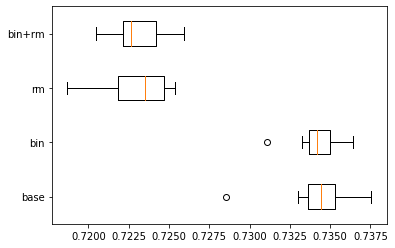

In [23]:
plt.boxplot(accuracy, vert=False, labels=['A','B','C','D','E','F','G'])